In [4]:
#import networkx as nx
import numpy as np
import shap
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as datasets # load_digits, load_iris, load_brest_cancer
import seaborn as sns

#from minisom import MiniSom as SOM
from scipy.spatial import distance_matrix
from sklearn.ensemble import RandomForestClassifier

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
digits_info = datasets.load_digits()

In [8]:
#print(digits_info['DESCR'])

In [9]:
data = digits_info['data']
x = pd.DataFrame(data, columns=digits_info['feature_names'])
y = pd.Series(digits_info['target'])

In [10]:
y

0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Length: 1797, dtype: int64

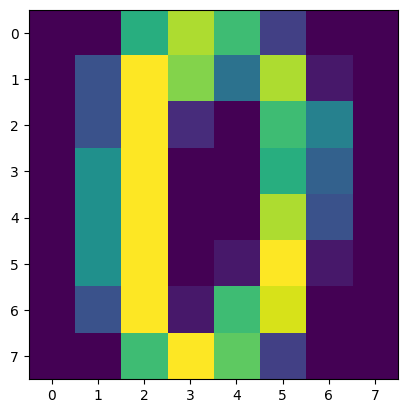

In [11]:
#plt.imshow(np.array(x.loc[0]).resize(8,8))
plt.imshow(np.array(x.sample(frac=0.5).iloc[0]).reshape(8,8))

In [12]:
group_indexes = {}
for val in sorted(y.unique()):
    group_indexes[val] = list(y[y==val].index)

In [13]:
new_y = pd.DataFrame(y, columns=['target'])

In [14]:
#new_y['related_elements'] = new_y.target.apply(lambda x: group_indexes.get(x))

In [29]:
response_dataframes = []
for key in group_indexes.keys():
    for key2 in group_indexes.keys():
        response = 0
        if key==key2:
            response=1
        a = list(new_y[new_y.target==key].index)
        b = list(new_y[new_y.target==key2].index)  
        df = pd.DataFrame(pd.Series(a, name='from'))
        df['to'] = [b]*len(a)
        response_dataframe = df.explode('to')
        response_dataframe['similarity'] = response
        response_dataframes.append(response_dataframe)

r_df = pd.concat(response_dataframes).reset_index(drop=True)

In [30]:
r_df2 = r_df.merge(x.reset_index().rename(columns={'index': 'from'}), on='from', how='left').drop('from', axis=1)

In [31]:
r_df3 = r_df2.merge(x.reset_index().rename(columns={'index': 'to'}), on='to', how='left').drop('to', axis=1)

In [32]:
predictors = r_df3.drop('similarity', axis=1)
target = r_df3.similarity

In [33]:
train_index, test_index = train_test_split(r_df['from'].unique(), train_size=0.7)
real_train_index = r_df[(r_df['from'].isin(train_index)) & (~r_df['to'].isin(test_index))].index
real_test_index = r_df[(r_df['from'].isin(test_index)) & (~r_df['to'].isin(train_index))].index

In [34]:
x_train = predictors.loc[real_train_index]
y_train = target.loc[real_train_index]

x_test = predictors.loc[real_test_index]
y_test = target.loc[real_test_index]

In [35]:
model=RandomForestClassifier()

In [37]:
model.fit(x_train, y_train)

RandomForestClassifier()

In [38]:
pred = model.predict_proba(x_test)[:, 1]

In [39]:
roc_auc_score(y_test, pred)

0.9967537490885292

In [40]:
average_precision_score(y_test, pred)

0.9785828414377534

<Axes: ylabel='Probability'>

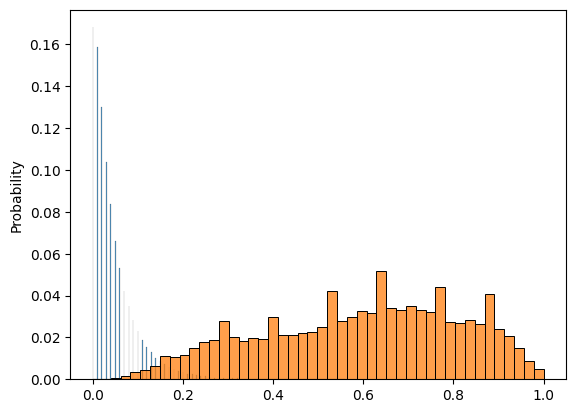

In [41]:
sns.histplot(pred[y_test==0], stat='probability')
sns.histplot(pred[y_test==1], stat='probability')

In [77]:
r_df_with_vals = r_df.copy()
r_df_with_vals = r_df_with_vals.merge(
    pd.DataFrame(y).reset_index(), left_on='from', right_on='index'
).drop('index', axis=1).rename(columns={0:'number_value_from'})

r_df_with_vals = r_df_with_vals.merge(
    pd.DataFrame(y).reset_index(), left_on='to', right_on='index'
).drop('index', axis=1).rename(columns={0:'number_value_to'})

#r_df_with_vals['from_val'] = r_df_with_vals['from'].apply(lambda val: y.to_dict().get(val))
#r_df_with_vals['to_val'] = r_df_with_vals['to'].apply(lambda val: y.to_dict().get(val))

In [282]:
additional_step = r_df_with_vals.loc[real_test_index]
sample_step = x.loc[additional_step[(additional_step.similarity==1) & (additional_step.number_value_from==1)]['from'].unique()].sample(1)

In [283]:
sample_step
sample_step2 = sample_step.copy()
for col in sample_step2:
    sample_step2[col]=0

In [284]:
for col in sample_step2.columns:
    for val in range(0,17):
        sample_step2[col] = val

In [383]:
def generate_random_sample(idx):
    sample_dict = {}
    for pixel1 in range(0,8):
        for pixel2 in range(0,8):
            sample_dict[f'pixel_{pixel1}_{pixel2}'] = {idx: np.random.randint(0, 16)}
    return pd.DataFrame(sample_dict)

def crossover(p1, p2, r_cross):
    c1, c2 = p1.copy(), p2.copy()
    if np.random.uniform(0, 1) < r_cross:
        pt = np.random.randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return c1, c2

def children_adequation(c1, base):
    children_transformation = pd.DataFrame(pd.Series(c1, index=[col for col in parents.columns if '_y' in col])).T
    base_accoplation = pd.concat([pd.DataFrame(base).T.reset_index(drop=True), children_transformation], axis=1)
    return base_accoplation

def apply_mutation(child, columns):
    child = child.copy()
    for col in np.random.choice(relevant_columns_with_y, np.random.randint(1, len(relevant_columns_with_y)-2)):
        child[col] = (child[col] + np.random.choice([-2,-1,0,1,2,3])).abs()
    return child

In [433]:
# Init random stuff

ss1 = sample_step.rename(columns={col:f'{col}_x' for col in sample_step.columns})
ss_df_to_eval_list = []
for _ in range(1000):
    ss2 = generate_random_sample(ss1.index[0]).rename(columns={col:f'{col}_y' for col in sample_step.columns})
    ss_df_to_eval = pd.concat([ss1,ss2], axis=1)
    ss_df_to_eval_list.append(ss_df_to_eval)
    
ss_df_to_eval_list_all = pd.concat(ss_df_to_eval_list).reset_index(drop=True)
ss_df_to_eval_list_all['pred'] = model.predict_proba(ss_df_to_eval_list_all)[:, 1]
sorted_ss_df_to_eval_list_all = ss_df_to_eval_list_all.sort_values('pred')

In [434]:
final_prediction = sorted_ss_df_to_eval_list_all.iloc[-1].pred

In [435]:
counter = 0
while final_prediction < 0.9 and counter < 100000:
    parents_fit = sorted_ss_df_to_eval_list_all.tail(10).sample(frac=1)
    parents_unfit = sorted_ss_df_to_eval_list_all.head(3).sample(frac=1)

    parents = pd.concat([parents_fit, parents_unfit])

    base = parents[[col for col in parents.columns if '_x' in col]].iloc[0]

    #p1 = parents[[col for col in parents.columns if '_y' in col]].iloc[0].to_list()
    #p2 = parents[[col for col in parents.columns if '_y' in col]].iloc[1].to_list()
    relevant_columns_with_y = [col for col in parents.columns if '_y' in col]

    child_pool = []
    for p1_position_idx in range(10):
        for p2_position_idx in range(10):
            if p1_position_idx!=p2_position_idx:

                p1 = parents[relevant_columns_with_y].iloc[p1_position_idx].to_list()
                p2 = parents[relevant_columns_with_y].iloc[p2_position_idx].to_list()
                for time_to_have_pairs in range(3):
                    c1, c2 = crossover(p1, p2, 0.9)
                    child1 = children_adequation(c1, base=base)
                    child2 = children_adequation(c2, base=base)
                    child3 = apply_mutation(child1, relevant_columns_with_y)
                    child4 = apply_mutation(child2, relevant_columns_with_y)
                    child_pool.append(child1)
                    child_pool.append(child2)
                    child_pool.append(child3)
                    child_pool.append(child4)

    child_pool_df = pd.concat(child_pool).drop_duplicates()
    # Include mutations

    ss_df_to_eval_list_all = child_pool_df.copy()
    ss_df_to_eval_list_all['pred'] = model.predict_proba(ss_df_to_eval_list_all)[:, 1]
    sorted_ss_df_to_eval_list_all = ss_df_to_eval_list_all.sort_values('pred')
    final_prediction = sorted_ss_df_to_eval_list_all.tail().pred.mean()
    counter+=1
    if counter%10:
        print(final_prediction)
counter, final_prediction

0.21400000000000002
0.31
0.36000000000000004
0.418
0.45600000000000007
0.48
0.51
0.524
0.556
0.612
0.62
0.632
0.65
0.65
0.65
0.652
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.66
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.68
0.682
0.69
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.7
0.702
0.71
0.71
0.712
0.722
0.73
0.73
0.734
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.74
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0.75
0

0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000000002
0.8100000000

0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82


0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82
0.82


KeyboardInterrupt: 

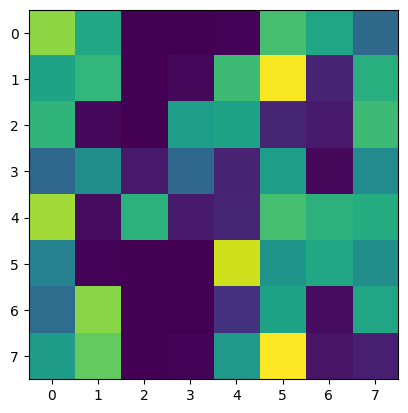

In [436]:
plt.imshow(sorted_ss_df_to_eval_list_all.iloc[-1].loc[[col for col in parents.columns if '_y' in col]].values.reshape(8,8))